# Imports

In [102]:
import os
import pickle
import pandas as pd
import numpy as np
import datetime as dt

import yfinance as yf

from dash_bootstrap_templates import load_figure_template
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import ast
from gensim import corpora, models
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import spacy

import xgboost as xgb

import scipy
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from collections import Counter

In [27]:
pd.set_option('display.max_columns', None)
load_figure_template('minty')

In [28]:
def save_pkl_file(object, filepath):
    # Retrieve directory
    directory = os.path.dirname(filepath)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Folder created at {directory}")
    with open(filepath, 'wb') as file:
        pickle.dump(object, file)

def load_pkl_file(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)

In [29]:
REFRESH = False

# 1. Data Exploration

In [30]:
data_1 = pd.read_csv("data/daily_financial_news/analyst_ratings_processed.csv", index_col=0)
data_1.head()

,title,date,stock
0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A


In [31]:
data_1['date'] = data_1['date'].str.split(' ', expand=True).iloc[:, 0]

In [32]:
data_1.head()

,title,date,stock
0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,A
1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,A
2.0,71 Biggest Movers From Friday,2020-05-26,A
3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,A
4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22,A


In [33]:
data_1['stock'].nunique()

6192

In [34]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1400469 entries, 0.0 to 1413848.0
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   title   1400469 non-null  object
 1   date    1399180 non-null  object
 2   stock   1397891 non-null  object
dtypes: object(3)
memory usage: 42.7+ MB


## Drop Null Values

In [35]:
print(data_1.isna().sum())

title       0
date     1289
stock    2578
dtype: int64


In [36]:
print(data_1.shape)

(1400469, 3)


In [37]:
data_1[data_1['date'].isna()]

,title,date,stock
5714.0,Sterne Agee Provides Color on Aaron's,NaN,NaN
7021.0,Goldman Sachs Updates on Car Parts,NaN,NaN
13735.0,American Campus to Offer 15M Shares,NaN,NaN
13764.0,American Campus Communities Reports Q2 FFOM of...,NaN,NaN
14421.0,Positive Seeking Alpha Article on Aceto Corpor...,NaN,NaN
...,...,...,...
1410993.0,Zynga Loses Its CTO of Mobile -AllThingsD,NaN,NaN
1411126.0,Looks Like Zynga Just Bought OMGPOP For $200 M...,NaN,NaN
1411150.0,Zynga Lead Game Designer Leaving the Company -...,NaN,NaN
1412824.0,Waiting on Several IPOs This Morning:,NaN,NaN


In [38]:
data_1.dropna(subset=['date'],inplace=True)
data_1.dropna(subset=['stock'],inplace=True)

In [39]:
print(data_1.shape)

(1397891, 3)


In [40]:
print(data_1.isna().sum())

title    0
date     0
stock    0
dtype: int64


In [41]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1397891 entries, 0.0 to 1413848.0
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   title   1397891 non-null  object
 1   date    1397891 non-null  object
 2   stock   1397891 non-null  object
dtypes: object(3)
memory usage: 42.7+ MB


## Filter stocks

In [42]:
# Filter dataset down to stocks with top 100 number of headlines
top_100_stocks_by_headlines = data_1.groupby('stock').size().reset_index(name='size').sort_values('size', ascending=False).reset_index(drop=True).iloc[:100]
top_100_stocks_by_headlines.head()

,stock,size
0,MRK,3334
1,MS,3242
2,MU,3144
3,NVDA,3133
4,QQQ,3100


In [43]:
data_1 = data_1[data_1['stock'].isin(top_100_stocks_by_headlines.stock)]

In [44]:
data_1.shape

(212110, 3)

## Clean Text Data

In [45]:
data_1['title'] = data_1['title'].str.lower()
data_1

,title,date,stock
0.0,stocks that hit 52-week highs on friday,2020-06-05,A
1.0,stocks that hit 52-week highs on wednesday,2020-06-03,A
2.0,71 biggest movers from friday,2020-05-26,A
3.0,46 stocks moving in friday's mid-day session,2020-05-22,A
4.0,b of a securities maintains neutral on agilent...,2020-05-22,A
...,...,...,...
1411294.0,is zynga's pre-thanksgiving ipo a turkey?,2011-11-06,ZNGA
1411295.0,zynga files new s-1 stament for ipo; cash on h...,2011-11-04,ZNGA
1411296.0,"zynga ipo to debut week before thanksgiving, a...",2011-10-24,ZNGA
1411297.0,ipo filing: zynga amends s-1 filing,2011-10-14,ZNGA


### Remove Punctuations

In [46]:
import string

def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])

data_1['title'] = data_1['title'].apply(remove_punctuation)

In [47]:
data_1.head()

,title,date,stock
0.0,stocks that hit week highs on friday,2020-06-05,A
1.0,stocks that hit week highs on wednesday,2020-06-03,A
2.0,biggest movers from friday,2020-05-26,A
3.0,stocks moving in fridays midday session,2020-05-22,A
4.0,b of a securities maintains neutral on agilent...,2020-05-22,A


In [48]:
data_1['tokens'] = data_1['title'].apply(lambda x: x.split())
data_1.head()

,title,date,stock,tokens
0.0,stocks that hit week highs on friday,2020-06-05,A,"[stocks, that, hit, week, highs, on, friday]"
1.0,stocks that hit week highs on wednesday,2020-06-03,A,"[stocks, that, hit, week, highs, on, wednesday]"
2.0,biggest movers from friday,2020-05-26,A,"[biggest, movers, from, friday]"
3.0,stocks moving in fridays midday session,2020-05-22,A,"[stocks, moving, in, fridays, midday, session]"
4.0,b of a securities maintains neutral on agilent...,2020-05-22,A,"[b, of, a, securities, maintains, neutral, on,..."


### Remove stop words

In [49]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop = stopwords.words('english')

data_1['tokens'] = data_1['tokens'].apply(lambda x: [word for word in x if word not in stop])

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


In [50]:
data_1.shape

(212110, 4)

### Lemmatize tokens

In [51]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

data_1['tokens'] = data_1['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


In [52]:
data_1.head()

,title,date,stock,tokens
0.0,stocks that hit week highs on friday,2020-06-05,A,"[stock, hit, week, high, friday]"
1.0,stocks that hit week highs on wednesday,2020-06-03,A,"[stock, hit, week, high, wednesday]"
2.0,biggest movers from friday,2020-05-26,A,"[biggest, mover, friday]"
3.0,stocks moving in fridays midday session,2020-05-22,A,"[stock, moving, friday, midday, session]"
4.0,b of a securities maintains neutral on agilent...,2020-05-22,A,"[b, security, maintains, neutral, agilent, tec..."


In [53]:
data_1['preprocessed_text'] = data_1['tokens'].apply(' '.join)
data_1

,title,date,stock,tokens,preprocessed_text
0.0,stocks that hit week highs on friday,2020-06-05,A,"[stock, hit, week, high, friday]",stock hit week high friday
1.0,stocks that hit week highs on wednesday,2020-06-03,A,"[stock, hit, week, high, wednesday]",stock hit week high wednesday
2.0,biggest movers from friday,2020-05-26,A,"[biggest, mover, friday]",biggest mover friday
3.0,stocks moving in fridays midday session,2020-05-22,A,"[stock, moving, friday, midday, session]",stock moving friday midday session
4.0,b of a securities maintains neutral on agilent...,2020-05-22,A,"[b, security, maintains, neutral, agilent, tec...",b security maintains neutral agilent technolog...
...,...,...,...,...,...
1411294.0,is zyngas prethanksgiving ipo a turkey,2011-11-06,ZNGA,"[zyngas, prethanksgiving, ipo, turkey]",zyngas prethanksgiving ipo turkey
1411295.0,zynga files new s stament for ipo cash on hand...,2011-11-04,ZNGA,"[zynga, file, new, stament, ipo, cash, hand, s...",zynga file new stament ipo cash hand slightly ...
1411296.0,zynga ipo to debut week before thanksgiving ac...,2011-10-24,ZNGA,"[zynga, ipo, debut, week, thanksgiving, accord...",zynga ipo debut week thanksgiving according so...
1411297.0,ipo filing zynga amends s filing,2011-10-14,ZNGA,"[ipo, filing, zynga, amends, filing]",ipo filing zynga amends filing


In [54]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
# NLTK Sentiment Intensity Analyzer uses a 'Bag of Words' approach
# it removes stop words and scores each word individually before compounding

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


In [55]:
data_duplicate = data_1.copy()
data_duplicate['sentiment_score'] = data_duplicate['preprocessed_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
data_duplicate

,title,date,stock,tokens,preprocessed_text,sentiment_score
0.0,stocks that hit week highs on friday,2020-06-05,A,"[stock, hit, week, high, friday]",stock hit week high friday,0.0000
1.0,stocks that hit week highs on wednesday,2020-06-03,A,"[stock, hit, week, high, wednesday]",stock hit week high wednesday,0.0000
2.0,biggest movers from friday,2020-05-26,A,"[biggest, mover, friday]",biggest mover friday,0.0000
3.0,stocks moving in fridays midday session,2020-05-22,A,"[stock, moving, friday, midday, session]",stock moving friday midday session,0.0000
4.0,b of a securities maintains neutral on agilent...,2020-05-22,A,"[b, security, maintains, neutral, agilent, tec...",b security maintains neutral agilent technolog...,0.3400
...,...,...,...,...,...,...
1411294.0,is zyngas prethanksgiving ipo a turkey,2011-11-06,ZNGA,"[zyngas, prethanksgiving, ipo, turkey]",zyngas prethanksgiving ipo turkey,0.0000
1411295.0,zynga files new s stament for ipo cash on hand...,2011-11-04,ZNGA,"[zynga, file, new, stament, ipo, cash, hand, s...",zynga file new stament ipo cash hand slightly ...,0.4939
1411296.0,zynga ipo to debut week before thanksgiving ac...,2011-10-24,ZNGA,"[zynga, ipo, debut, week, thanksgiving, accord...",zynga ipo debut week thanksgiving according so...,0.0000
1411297.0,ipo filing zynga amends s filing,2011-10-14,ZNGA,"[ipo, filing, zynga, amends, filing]",ipo filing zynga amends filing,0.0000


In [56]:
data_duplicate['sentiment_score'].describe()

count    212110.000000
mean          0.072493
std           0.291640
min          -0.957800
25%           0.000000
50%           0.000000
75%           0.273200
max           0.974400
Name: sentiment_score, dtype: float64

In [57]:
data_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212110 entries, 0.0 to 1411298.0
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   title              212110 non-null  object 
 1   date               212110 non-null  object 
 2   stock              212110 non-null  object 
 3   tokens             212110 non-null  object 
 4   preprocessed_text  212110 non-null  object 
 5   sentiment_score    212110 non-null  float64
dtypes: float64(1), object(5)
memory usage: 11.3+ MB


In [58]:
signals_df = data_duplicate.copy()

In [59]:
signals_df.dtypes

title                 object
date                  object
stock                 object
tokens                object
preprocessed_text     object
sentiment_score      float64
dtype: object

In [60]:
# There are some stocks that have multiple news articles on the same day
# Have to handle these cases
# non_dup_signals_df = signals_df.groupby(['date', 'stock'])['sentiment_score'].mean().reset_index(name='sentiment_score')

# 2. Pull yfinance Data

In [61]:
tickers = data_duplicate.stock.unique()

In [62]:
start_date, end_date = data_duplicate.date.sort_values().iloc[0], data_duplicate.date.sort_values().iloc[-1]

In [63]:
data = yf.download(list(tickers), start=start_date, end=end_date)

[*********************100%%**********************]  100 of 100 completed


13 Failed downloads:
['CHK', 'SHLD']: Exception("%ticker%: Data doesn't exist for startDate = 1240977600, endDate = 1591848000")
['JCP', 'ZNGA', 'BBBY', 'APC', 'MYL', 'MON', 'AGN']: Exception('%ticker%: No timezone found, symbol may be delisted')
['PCLN', 'LNKD', 'GMCR', 'BBRY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-04-29 -> 2020-06-11)')


In [64]:
adj_close_data = data['Adj Close']
adj_close_data

,A,ADBE,AGN,AIG,APC,ATVI,AVGO,AXP,AZN,BABA,BAC,BBBY,BBRY,BIDU,BIIB,BMY,CAT,CHK,CMCSA,CMG,COP,CSX,CVS,DAL,DB,DE,DG,DISH,EA,EBAY,EWI,EWJ,EWP,EWU,EWZ,FCX,FDX,FSLR,GILD,GLD,GMCR,GME,GOOGL,GPRO,GPS,GRPN,GSK,HAL,HD,JCP,JNJ,JWN,KO,KR,KSS,LLY,LMT,LNKD,LOW,M,MA,MCD,MDT,MON,MRK,MS,MU,MYL,NFLX,NOK,NVDA,NVS,ORCL,P,PCG,PCLN,PEP,PFE,QCOM,QQQ,RAD,RIG,SHLD,SLV,SNY,STX,TM,TSLA,TWX,TXN,URBN,VMW,VZ,WDC,WFC,XLF,XRT,YELP,YUM,ZNGA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-04-29,11.629642,26.750000,NaN,18.591230,NaN,9.411403,NaN,20.044996,10.166079,NaN,7.104774,NaN,NaN,22.729000,47.419998,11.753111,22.862494,NaN,5.695951,81.440002,18.800182,2.540430,22.742418,5.497928,41.299328,30.027071,NaN,10.818489,20.110626,6.424495,19.359621,27.310286,18.744003,13.388993,25.523720,15.138298,47.783798,151.669998,17.613052,88.330002,NaN,5.064899,9.796547,NaN,9.834330,NaN,14.683729,16.406252,18.524668,NaN,33.340843,14.146770,13.633770,8.505033,26.751787,21.300949,50.072933,NaN,16.353598,8.172962,16.549150,36.126411,22.771397,NaN,13.784692,17.328438,4.764460,NaN,6.461429,8.681168,2.495399,20.195534,16.104475,NaN,27.012770,NaN,33.043442,7.421928,29.862148,29.781527,17.200001,53.491886,NaN,12.550000,16.337105,4.077265,66.110992,NaN,15.884645,12.042562,18.360001,17.648695,13.880991,17.701693,13.738088,6.807956,10.970397,NaN,18.446480,NaN
2009-04-30,11.777996,27.350000,NaN,18.195675,NaN,9.446487,NaN,20.261921,9.726616,NaN,7.309403,NaN,NaN,23.290001,48.340000,11.783797,24.145075,NaN,5.778175,81.089996,18.569197,2.524221,23.466042,5.453733,39.818378,30.811163,NaN,10.810329,20.012293,6.424495,19.437265,27.150770,18.929377,13.562426,25.455992,15.762901,48.380333,187.289993,17.177979,87.269997,NaN,5.076683,9.909159,NaN,10.127596,NaN,14.640889,16.197962,18.510605,NaN,34.209808,14.787129,13.742308,8.297782,27.742834,21.020006,49.724697,NaN,16.538208,8.620365,17.035759,35.382774,22.986893,NaN,13.980788,17.756582,4.803835,NaN,6.472857,8.837418,2.633012,20.179569,15.890849,NaN,26.739037,NaN,32.591492,7.383244,29.335346,30.079861,18.000000,53.658886,NaN,12.210000,16.354187,4.471838,66.811516,NaN,15.776243,12.513730,19.490000,17.771349,13.849039,18.881809,13.765610,6.714097,11.338801,NaN,18.179384,NaN
2009-05-01,12.132753,27.459999,NaN,18.195675,NaN,9.507887,NaN,19.514759,9.782244,NaN,7.121142,NaN,NaN,23.561001,46.259998,11.839029,25.285137,NaN,6.114551,80.160004,19.248564,2.607822,23.820457,5.674709,40.349998,32.020905,NaN,11.732267,19.668098,6.440097,19.838436,27.565525,19.060223,13.932414,26.404238,16.439243,47.662762,180.889999,16.806664,86.949997,NaN,4.938657,9.852102,NaN,10.277491,NaN,14.569497,16.710667,18.123796,NaN,34.360081,14.702188,13.557159,8.432109,26.036045,21.383959,51.662251,NaN,16.038221,8.513238,16.056042,34.791840,23.101828,NaN,14.015400,19.394032,4.813680,NaN,6.354286,8.937416,2.676589,20.163601,15.890849,NaN,27.228874,NaN,32.611137,7.504823,29.571014,30.158834,18.400000,56.155746,NaN,12.310000,16.365574,4.630764,66.819939,NaN,16.506149,12.437518,19.139999,17.307985,13.944899,18.777437,13.490434,6.664036,11.150505,NaN,18.043097,NaN
2009-05-04,12.526210,26.690001,NaN,19.250492,NaN,9.692080,NaN,21.916939,10.010319,NaN,8.496260,NaN,NaN,24.825001,46.610001,11.986332,26.113050,NaN,6.222940,82.820000,19.869047,2.738342,23.650627,6.205057,43.342266,33.663776,NaN,12.115727,20.690842,6.529814,20.640774,28.299334,19.638138,14.302401,27.979008,17.976725,51.449505,193.639999,16.840422,88.639999,NaN,4.938657,10.059560,NaN,11.039995,NaN,14.731325,17.856218,18.433239,NaN,35.124512,15.656197,13.780607,8.589473,26.776264,21.588287,50.870750,NaN,16.168983,9.300919,16.621586,35.037518,23.777063,NaN,14.199969,20.295382,5.187748,NaN,6.420000,9.637410,2.821085,20.536209,15.586830,NaN,27.272097,NaN,32.159199,7.725877,30.049309,30.755522,19.000000,58.843468,NaN,12.830000,16.667379,4.981495,68.862465,NaN,17.662449,12.721600,20.360001,18.166571,14.168566,19.475880,16.682465,7.339828,11.666274,NaN,18.560951,NaN
2009-05-

In [65]:
# Tickers that don't have data
missing_data_tickers = adj_close_data.columns[adj_close_data.isna().sum()/adj_close_data.shape[0] == 1]

# Drop missing tickers
adj_close_data = adj_close_data.drop(columns=missing_data_tickers)

In [66]:
# Drop other tickers
adj_close_data = adj_close_data.dropna(axis=1)

In [67]:
any(adj_close_data.isna().sum() > 0)

False

In [68]:
returns_df = adj_close_data.pct_change().dropna().reset_index().rename(columns={'Date': 'date'})

In [69]:
returns_df_melt = returns_df.melt(id_vars='date', var_name='stock', value_name='daily_returns')
returns_df_melt['date'] = pd.to_datetime(returns_df_melt['date'])
returns_df_melt

,date,stock,daily_returns
0,2009-04-30,A,0.012757
1,2009-05-01,A,0.030120
2,2009-05-04,A,0.032429
3,2009-05-05,A,-0.035530
4,2009-05-06,A,0.026696
...,...,...,...
218239,2020-06-04,YUM,0.004548
218240,2020-06-05,YUM,0.016107
218241,2020-06-08,YUM,-0.005491
218242,2020-06-09,YUM,-0.004480


In [70]:
returns_df_melt.dtypes

date             datetime64[ns]
stock                    object
daily_returns           float64
dtype: object

In [104]:
# Save returns df as pickle
save_pkl_file(returns_df, 'cache/dataframes/returns_df.pkl')
save_pkl_file(returns_df_melt, 'cache/dataframes/returns_df_melt.pkl')

In [71]:
signals_df['date'] = pd.to_datetime(signals_df['date'])

In [72]:
merged_df = pd.merge(returns_df_melt, signals_df, on=['date', 'stock'], how='left').dropna()
merged_df

,date,stock,daily_returns,title,tokens,preprocessed_text,sentiment_score
21,2009-06-01,A,0.035656,supertrades two week highs and others about ...,"[supertrades, two, week, high, others, join]",supertrades two week high others join,0.2960
51,2009-07-14,A,0.005157,skystar biopharmaceutical announces expansion ...,"[skystar, biopharmaceutical, announces, expans...",skystar biopharmaceutical announces expansion ...,0.3818
63,2009-07-30,A,0.023420,the goldsilver ratio from to and now,"[goldsilver, ratio]",goldsilver ratio,0.0000
66,2009-08-04,A,0.009186,a simulation of chinas diversificationwritedown,"[simulation, china, diversificationwritedown]",simulation china diversificationwritedown,0.0000
68,2009-08-06,A,-0.011050,brampton brick reports results for the second ...,"[brampton, brick, report, result, second, quar...",brampton brick report result second quarter en...,0.0000
...,...,...,...,...,...,...,...
307771,2020-05-29,YUM,-0.012328,shares of beyond meat ticking higher barrons p...,"[share, beyond, meat, ticking, higher, barrons...",share beyond meat ticking higher barrons publi...,0.2960
307774,2020-06-03,YUM,0.025485,shares of several companies in the hotel resta...,"[share, several, company, hotel, restaurant, f...",share several company hotel restaurant fitness...,0.6908
307777,2020-06-08,YUM,-0.005491,pe ratio insights for yum brands,"[pe, ratio, insight, yum, brand]",pe ratio insight yum brand,0.0000
307779,2020-06-10,YUM,-0.015383,yum says reopened k stores during week of jun ...,"[yum, say, reopened, k, store, week, jun, k, r...",yum say reopened k store week jun k restaurant...,0.0000


In [73]:
# Count number of stocks per date
merged_df['num_stocks_by_date'] = merged_df.groupby('date').transform('size')

# Select data where there were at least 10 stocks for each date
merged_df_filtered = merged_df[merged_df['num_stocks_by_date'] >= 10]

# Drop num_stocks_by_date column
ml_df = merged_df_filtered.drop(columns='num_stocks_by_date').reset_index(drop=True)

# 3. Build Machine Learning Dataframes and Features

## Check Dataframes

In [455]:
ml_df

## Additional Feature Engineer

### Create Day of Week Feature

In [ ]:
ml_df['date'] = pd.to_datetime(ml_df['date'])
ml_df['day_of_week'] = ml_df['date'].dt.dayofweek

In [ ]:
ml_df

### Create Topic Feature using Latent Dirichlet Allocation (LDA)

In [ ]:
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return s

In [ ]:
ml_df['tokens'] = ml_df['tokens'].apply(safe_literal_eval)

# Create Dictionary (takes 5 minutes to run)
id2word = corpora.Dictionary(ml_df['tokens'])

# Term Document Frequency (Corpus)
corpus = [id2word.doc2bow(text) for text in ml_df['tokens']]

lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=42, passes=10)

In [ ]:
# Inspect Topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

# Inspect Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=ml_df['tokens'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Function to get the dominant topic
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc_topics in lda_model[corpus]:
        # Sort the topics by their assigned proportions
        sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
        # Get the topic number of the highest proportion topic
        dominant_topic = sorted_topics[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

In [ ]:
# Get the dominant topic on the data
ml_df['dominant_topic'] = get_dominant_topic(lda_model, corpus)

### Create Entities Count Feature using Named Entity Recognizer (NER)

In [ ]:
# Load the spaCy model
spacy_nlp_model = spacy.load('en_core_web_sm')

def extract_entities(text):
    # Process the text with the NER model
    doc = spacy_nlp_model(text)

    # Extract entities that are either PERSON or ORG (companies). You can adjust this as needed.
    entities = [ent.text for ent in doc.ents if ent.label_ in ['PERSON', 'ORG']]

    return entities

In [ ]:
# Extract entities from data (takes 10 - 20 minutes to run)
ml_df['entities'] = ml_df['preprocessed_text'].apply(extract_entities)

In [ ]:
ml_df['entities_count'] = ml_df['entities'].apply(len)
ml_df.drop('entities', axis=1, inplace=True)

In [ ]:
ml_df_final = ml_df[['date', 'stock', 'daily_returns', 'sentiment_score', 'day_of_week', 'dominant_topic', 'entities_count']].copy()

In [ ]:
# Save to pkl file
save_pkl_file(ml_df_final, 'cache/dataframes/ml_df.pkl')

## Feature Engineer Evaluation

### Correlation Matrix

# 4. Machine Learning Model Creation

## Create Functions for Train Test Split, One Hot Encoding, Scoring


In [ ]:
# Define function for train test split
def ts_train_test_split(data, test_size):
    """Takes in data and output train set and test set in that order

    Args:
        data (pd.DataFrame or pd.Series): Data to split into train and test
        test_size (float): Percentage for test size

    Returns:
        tuple: train set, test set
    """
    train_size = 1-test_size
    train_idx = round(X.shape[0] * train_size)
    return data.iloc[:train_idx], data.iloc[train_idx:]

In [10]:
def one_hot_encode(X_train, X_valid, columns_to_encode):
    # Initialize OneHotEncoder
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Drop date column if it exists
    X_train = X_train.drop(columns=['date'], errors='ignore')
    X_valid = X_valid.drop(columns=['date'], errors='ignore')

    # Create empty DataFrames to accumulate our one-hot encoded columns
    OH_X_train_accum = X_train.drop(columns=columns_to_encode)
    OH_X_valid_accum = X_valid.drop(columns=columns_to_encode)

    for col in columns_to_encode:
        # One-hot Encode the current column for Training and Validation Data
        OH_cols_train = pd.DataFrame(one_hot_encoder.fit_transform(X_train[[col]]))
        OH_cols_valid = pd.DataFrame(one_hot_encoder.transform(X_valid[[col]]))

        # Assign Column Names after One-Hot Encoding and Restore Index
        OH_cols_train.columns = one_hot_encoder.get_feature_names_out([col])
        OH_cols_valid.columns = one_hot_encoder.get_feature_names_out([col])
        OH_cols_train.index = X_train.index
        OH_cols_valid.index = X_valid.index

        # Concatenate One-Hot Encoded Columns to the accumulating DataFrame
        OH_X_train_accum = pd.concat([OH_X_train_accum, OH_cols_train], axis=1)
        OH_X_valid_accum = pd.concat([OH_X_valid_accum, OH_cols_valid], axis=1)

    # Ensure all columns have string type
    OH_X_train_accum.columns = OH_X_train_accum.columns.astype(str)
    OH_X_valid_accum.columns = OH_X_valid_accum.columns.astype(str)

    return OH_X_train_accum, OH_X_valid_accum

In [11]:
def score_model(model, X_t, X_v, y_t, y_v):
    # Fit Model
    model.fit(X_t, y_t)

    # Predict
    preds = model.predict(X_v)

    # Check MAE
    mae = mean_absolute_error(y_v, preds)
    mse = mean_squared_error(y_v, preds)
    return preds, mae, mse

In [12]:
ml_df_final= load_pkl_file('cache/dataframes/ml_df.pkl')

## Train-Test Split

In [13]:
# Split Data into Features and Target
# Sort values by date
X = ml_df_final.sort_values("date").drop('daily_returns', axis=1).reset_index(drop=True)
y = ml_df_final.sort_values("date")['daily_returns'].reset_index(drop=True)

# Split Data into Training and Validation Sets
X_train, X_valid = ts_train_test_split(X, test_size=0.2)
y_train, y_valid = ts_train_test_split(y, test_size=0.2)

# Use one_hot_encode function to get One-Hot Encoded Training and Validation Data
columns_to_encode = ['stock', 'day_of_week', 'dominant_topic']
OH_X_train, OH_X_valid = one_hot_encode(X_train, X_valid, columns_to_encode)

In [14]:
save_pkl_file(OH_X_train, 'cache/dataframes/OH_X_train.pkl')
save_pkl_file(OH_X_valid, 'cache/dataframes/OH_X_valid.pkl')
save_pkl_file(X_valid, 'cache/dataframes/X_valid.pkl')
save_pkl_file(y_train, 'cache/dataframes/y_train.pkl')
save_pkl_file(y_valid, 'cache/dataframes/y_valid.pkl')

## Linear Regression Model

In [15]:
if REFRESH :
    #Fit linear model
    linear_model = LinearRegression()
    preds_linear, mae_linear, mse_linear = score_model(linear_model, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with Linear Regression: {mae_linear}")
    print(f"Mean Squared Error with Linear Regression: {mse_linear}")
    save_pkl_file(linear_model, filepath='cache/ml_models/linear_model.pkl')
else :
    linear_model = load_pkl_file('cache/ml_models/linear_model.pkl')
    preds_linear, mae_linear, mse_linear = score_model(linear_model, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with Linear Regression: {mae_linear}")
    print(f"Mean Absolute Error with Linear Regression: {mse_linear}")

Mean Absolute Error with Linear Regression: 0.03119847390835908
Mean Absolute Error with Linear Regression: 0.003346715210413906


## XGBoost Model

In [20]:
if REFRESH :
    #Fit XGboost model
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=5)
    preds_xgboost, mae_xgboost, mse_xgboost = score_model(xgb_model, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with XGBoost: {mae_xgboost}")
    print(f"Mean Squared Error with XGBoost: {mse_xgboost}")
    save_pkl_file(xgb_model, filepath='cache/ml_models/xgb_model.pkl')
else :
    xgb_model = load_pkl_file('cache/ml_models/xgb_model.pkl')
    preds_xgboost, mae_xgboost, mse_xgboost = score_model(xgb_model, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with XGBoost: {mae_xgboost}")
    print(f"Mean Squared Error with XGBoost: {mse_xgboost}")

Mean Absolute Error with XGBoost: 0.03120226629609508
Mean Squared Error with XGBoost: 0.0033559779771645502


## K-Nearest Neighbours (KNN) Model

In [18]:
if REFRESH :
    #Fit K-Nearest Neighbours model
    knn_regressor = KNeighborsRegressor(n_neighbors=2000)
    preds_knn, mae_knn, mse_knn = score_model(knn_regressor, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with KNN: {mae_knn}")
    print(f"Mean Squared Error with KNN: {mse_knn}")
    save_pkl_file(knn_regressor, filepath='cache/ml_models/knn_regressor.pkl')
else :
    knn_regressor = load_pkl_file('cache/ml_models/knn_regressor.pkl')
    preds_knn, mae_knn, mse_knn = score_model(knn_regressor, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with KNN: {mae_knn}")
    print(f"Mean Squared Error with KNN: {mse_knn}")

/Users/weijie/Portfolio Projects/quant-fin-projects/qf209-nlp-project/qf209-project-venv/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


Mean Absolute Error with KNN: 0.031276222470643246
Mean Squared Error with KNN: 0.003372466850795345


## Multi-layer Perceptron (MLP) Neural Network Model

In [ ]:
if REFRESH :
    # Initialize the MLPRegressor model
    nn_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32),
                            activation='relu',
                            solver='adam',
                            max_iter=500,
                            early_stopping=True, # To use early stopping based on validation score
                            validation_fraction=0.2, # Fraction of training data to set aside as validation set for early stopping
                            verbose=True,
                            random_state=42)
    preds_nn, mae_nn, mse_nn = score_model(nn_model, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with Neural Network (MLPRegressor): {mae_nn}")
    print(f"Mean Squared Error with Neural Network (MLPRegressor): {mse_nn}")
    save_pkl_file(nn_model, filepath='cache/ml_models/nn_model.pkl')
else :
    nn_model = load_pkl_file('cache/ml_models/nn_model.pkl')
    preds_nn, mae_nn, mse_nn = score_model(nn_model, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with Neural Network (MLPRegressor): {mae_nn}")
    print(f"Mean Squared Error with Neural Network (MLPRegressor): {mse_nn}")

## Support Vector Regression (SVR) Model

In [ ]:
if REFRESH :
    # Create SVR pipeline
    def create_svr_pipeline():
        return make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1, kernel='rbf'))

    # Use your score_model function
    svr_model = create_svr_pipeline()
    preds_svr, mae_svr, mse_svr = score_model(svr_model, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with SVR: {mae_svr}")
    print(f"Mean Squared Error with SVR: {mse_svr}")
    save_pkl_file(svr_model, 'cache/ml_models/svr_model.pkl')
else :
    svr_model = load_pkl_file('cache/ml_models/svr_model.pkl')
    preds_svr, mae_svr, mse_svr = score_model(pipeline, OH_X_train, OH_X_valid, y_train, y_valid)
    print(f"Mean Absolute Error with SVR: {mae_svr}")
    print(f"Mean Squared Error with SVR: {mse_svr}")

# 5. Baseline Model Creation

## Mean Model

In [ ]:
# Calculate the mean of the training target values
mean_train = y_train.mean()

# Use the mean to make predictions for the validation set
mean_preds = [mean_train] * len(y_valid)

# Calculate the Mean Absolute Error (MAE) of the mean model
mae_mean = mean_absolute_error(y_valid, mean_preds)
mse_mean = mean_squared_error(y_valid, mean_preds)

print(f"Mean Absolute Error with Mean Model: {mae_mean}")

## Arimax Model

In [ ]:
# Define external regressors. Ensure there are no non-numeric or NaN values.
#exog_train = OH_X_train
# exog_valid = OH_X_valid

# Fit ARIMA-X model (ARIMA with external regressors, without the seasonal component) using the entire dataset
# model = ARIMA(y_train, exog=exog_train, order=(1,1,1))
#results = model.fit()
 
# Forecast
#forecast = results.predict(start=len(y_train), end=len(y_train) + len(y_valid) - 1, exog=exog_valid, dynamic=True)

# Calculate MAE
# mae_arimax = mean_absolute_error(y_valid, forecast)

# print(f"Mean Absolute Error with ARIMA-X: {mae_arimax}")

# 6. Model Evaluation

## Compare with Baseline Models

In [ ]:
import matplotlib.pyplot as plt

# Dictionaries for MAE and MSE values
mae_values = {
    'Linear': mae_linear,
    'XGBoost': mae_xgboost,
    'KNN': mae_knn,
    'SVR': mae_svr,
    'NN': mae_nn,
    'Mean Model': mae_mean,
    # 'Arima X Model': mae_arimax
}

mse_values = {
    'Linear': mse_linear,
    'XGBoost': mse_xgboost,
    'KNN': mse_knn,
    'SVR': mse_svr,
    'NN': mse_nn,
    'Mean Model': mse_mean,
    # 'Arima X Model': mse_arimax
}

# Sort the dictionaries by their values
sorted_mae = dict(sorted(mae_values.items(), key=lambda item: item[1]))
sorted_mse = dict(sorted(mse_values.items(), key=lambda item: item[1]))

# Define colors for models (you can change colors if you want)
colors = ['lightgrey' if model in ['Mean Model', 'Arima X Model'] else 'lightblue' for model in sorted_mae.keys()]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot MAE
mae_bars = axes[0].barh(list(sorted_mae.keys()), list(sorted_mae.values()), color=colors)
axes[0].set_xlabel('Mean Absolute Error (MAE)')
axes[0].set_title('Model Comparison based on MAE')

# Plot MSE
mse_bars = axes[1].barh(list(sorted_mse.keys()), list(sorted_mse.values()), color=colors)
axes[1].set_xlabel('Mean Squared Error (MSE)')
axes[1].set_title('Model Comparison based on MSE')

# Annotate bars with the actual values
for ax in axes:
    for bar in ax.patches:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                f'{bar.get_width():.4f}',
                va='center', ha='right', color='black', fontsize=10)

plt.tight_layout()
plt.show()


# 7. Feature Determination based on Model Evaluation

# 8. Tuning Features from NLP Packages

# 9. Hyperparameter Tuning for Machine Learning Models

# 10. Model Interpretation

# Portfolio Analytics Functions

In [23]:
def calc_daily_ptf_rtn(ptf_wgt, returns_df, ls=False):
    """Calculate daily portfolio returns given long form portfolio weights and returns

    Args:
        ptf_wgt (pd.DataFrame): Long form id level portfolio weights
        returns_df (pd.DataFrame): Long form id level returns
    """
    ptf_wgt['DATE'] = pd.to_datetime(ptf_wgt['DATE'])
    returns_df['DATE'] = pd.to_datetime(returns_df['DATE'])

    start_date = ptf_wgt['DATE'].min()
    end_date = ptf_wgt['DATE'].max()

    filtered_returns = returns_df[(returns_df['DATE'] <= end_date) & (returns_df['DATE'] >= start_date)].reset_index(drop=True)
    rebal_dates = ptf_wgt['DATE'].unique()

    # Add rebal date column to returns df
    filtered_returns['REBAL_DATE'] = filtered_returns['DATE'].apply(lambda x: rebal_dates[rebal_dates <= x].max())
    joint_df = pd.merge(ptf_wgt.rename(columns={'DATE': 'REBAL_DATE'}), filtered_returns, on=['REBAL_DATE', 'ID'], how='left')

    # Dates with no returns are filled as 0
    joint_df = joint_df.fillna(0)

    final_df = joint_df[['DATE', 'REBAL_DATE', 'ID', "WGT", "RTN"]].copy()

    # Cumulate asset returns within each rebal date
    final_df['ASSET_CUM_RTN'] = final_df.groupby(['REBAL_DATE', 'ID'])['RTN'].transform(lambda x: (1+x).cumprod())

    # Calculate asset's MTM weight
    final_df['MTM_WGT'] = final_df['WGT'] * final_df['ASSET_CUM_RTN']
    final_df['DATE'] = pd.to_datetime(final_df['DATE'])

    if ls:
        final_df['LONG/SHORT'] = np.where(final_df['MTM_WGT'] > 0, 'LONG', 'SHORT')
        final_df['PTF_MTM_BASE'] = final_df.groupby(["DATE", 'LONG/SHORT'])['MTM_WGT'].transform(lambda x: abs(x).sum())
        final_df['ASSET_WEIGHTS'] = final_df['MTM_WGT'] / final_df['PTF_MTM_BASE']

    else:
        # Calculate portfolio MTM base weight
        final_df['PTF_MTM_BASE'] = final_df.groupby("DATE")['MTM_WGT'].transform('sum')

        # Calculate renormed asset weights
        final_df['ASSET_WEIGHTS'] = final_df['MTM_WGT'] / final_df['PTF_MTM_BASE']

    # Shift asset weights down by 1 to represent implied lag of 1 day
    final_df['ASSET_WEIGHTS_SHIFTED'] = final_df.groupby('ID')['ASSET_WEIGHTS'].shift(1)

    # Drop NaNs introduced from shifting
    final_df = final_df.dropna(axis=0)

    ptf_rtn_df = final_df.groupby('DATE').apply(lambda x: (x['RTN'] * x['ASSET_WEIGHTS_SHIFTED']).sum()).reset_index(name="PTF_RTN")
    return ptf_rtn_df, final_df

def calc_annualised_returns(cumulative_returns:float, n, frequency):
    if frequency == "D":
        t = 252
    elif frequency == "M":
        t = 12
    return ((cumulative_returns + 1)**(t/n) - 1).values[0]

def calc_annualised_vol(ptf_rtn: pd.Series, frequency):
    if frequency == "D":
        n = 252 # 252 trading days in ptf_rtn
    elif frequency == "M":
        n = 12
    return ptf_rtn.std(ddof=1).values[0] * np.sqrt(n)

def calc_max_dd(ptf_rtn: pd.Series):
    # Cumulative returns must be base 1
    ptf_cumulative_return = (1+ptf_rtn).cumprod()

    # Calculate running max
    running_max = ptf_cumulative_return.cummax()

    # Drawdown
    drawdown = (ptf_cumulative_return-running_max)/running_max

    max_drawdown = drawdown.min().values[0]
    return max_drawdown

def calc_ptf_summary(ptf_rtn):
    ptf_cum_rtn = (ptf_rtn+1).prod()-1
    ptf_ann_rtn = calc_annualised_returns(ptf_cum_rtn, len(ptf_rtn), 'D')
    ptf_ann_vol = calc_annualised_vol(ptf_rtn, "D")
    ptf_max_dd = calc_max_dd(ptf_rtn)
    sharpe_ratio = ptf_ann_rtn/ptf_ann_vol
    downside_sd = ptf_rtn[ptf_rtn < 0].std()[0]
    sortino_ratio = ptf_ann_rtn/downside_sd
    return pd.DataFrame({
        'Metrics': ['Cumulative Returns', 'Annualised Returns',
                    'Annualised Volatility', 'Maximum Drawdown',
                    'Sharpe Ratio', 'Sortino Ratio'],
        'Values': [ptf_cum_rtn[0], ptf_ann_rtn, ptf_ann_vol, ptf_max_dd,
                   sharpe_ratio, sortino_ratio]
    })


In [80]:
class Backtest():
    def __init__(self, fitted_model, rtn_df, OH_X_train, y_train, OH_X_valid, X_valid):
        self.model = fitted_model
        self.rtn_df = rtn_df
        self.OH_X_train = OH_X_train
        self.OH_X_valid = OH_X_valid
        self.y_train = y_train
        self.X_valid = X_valid

        # Generate signal dataframe
        self.sig_df =  self.gen_signals_df()

        # Construct long short portfolio
        self.ls_ptf_wgt = self.constr_ls_ptf_wgt()

        # Construct long only portfolio
        self.lo_ptf_wgt = self.constr_lo_ptf_wgt()

        # Construct equal weighted portfolio
        self.eq_ptf_wgt = self.constr_eq_ptf_wgt()

        # Generate backtest analytics
        self.ptf_rtn_combined, self.cum_rtn_fig, self.summary_metrics = self.gen_backtest_analytics()

    def gen_signals_df(self):
        preds = self.model.predict(self.OH_X_valid)
        trading_df = self.X_valid.copy()

        # Create column of predicted returns
        trading_df['predicted_rtn'] = preds

        # Count number of stocks per date
        trading_df['num_stocks_by_date'] = trading_df.groupby('date').transform('size')

        # Select data where there were at least 10 stocks for each date
        trading_df_filtered = trading_df[trading_df['num_stocks_by_date'] >= 10]

        trading_df_filtered = trading_df_filtered[['date', 'stock', 'predicted_rtn']].reset_index(drop=True)

        # Handle duplicated stocks on a single date (stems from multiple headline for a stock on one day)
        trading_df_filtered_dd = trading_df_filtered.groupby(['date', 'stock'])['predicted_rtn'].mean().reset_index(name='predicted_rtn')

        # Create daily index and forward fill
        start_date = trading_df_filtered_dd['date'].min()
        end_date = trading_df_filtered_dd['date'].max()

        # Reesample to daily
        daily_index = pd.date_range(start=start_date, end=end_date, freq='B')

        # Pivot dataframe to forward fill to daily index so that we have signals everyday
        trading_df_filtered_wide = trading_df_filtered_dd.pivot(index='date', values='predicted_rtn', columns='stock')
        trading_df_filtered_wide = trading_df_filtered_wide.reindex(daily_index).fillna(method='ffill')

        final_signal_df = (trading_df_filtered_wide
                        .reset_index(names='date')
                        .rename_axis(None, axis=1)
                        .melt(id_vars='date', var_name='stock', value_name='signal')
                        .dropna(axis=0).reset_index(drop=True))
        final_signal_df = final_signal_df.rename(columns={
            'date': 'DATE',
            'stock': 'ID',
            'signal': 'SIGNAL'
        })
        return final_signal_df

    def constr_ls_ptf_wgt(self):
        # Create copy of sig_df
        sig_df = self.sig_df.copy()

        # Ranking the signals to reduce fat tails
        sig_df['RANKED_SIGNAL'] = sig_df.groupby('DATE')['SIGNAL'].transform(lambda x: scipy.stats.rankdata(x))
        sig_df = sig_df.sort_values(['DATE', 'ID']).reset_index(drop=True)

        # Long short weights calculated as the distance for median signal for each date
        sig_df['WGT'] = sig_df.groupby(['DATE'])['RANKED_SIGNAL'].transform(lambda x: x-x.median())

        # Renormalise weights to $1 long $1 short – dollar neutral strategy
        sig_df['DIRECTION'] = np.where(sig_df['WGT']>=0, 'LONG', 'SHORT')
        sig_df['RENORM_WGT'] = sig_df.groupby(['DATE', 'DIRECTION'])['WGT'].transform(lambda x: x/np.abs(x.sum()))
        return sig_df[['DATE', 'ID', 'RENORM_WGT']].rename(columns={'RENORM_WGT': 'WGT'})

    def constr_lo_ptf_wgt(self):
        # Create copy of sig_df
        sig_df = self.sig_df.copy()

        # Create long only signal df
        sig_df_lo = sig_df[sig_df['SIGNAL']>0].copy()

        # Reset index
        sig_df_lo = sig_df_lo.reset_index(drop=True)

        # Use predicted returns as weights
        sig_df_lo['WGT'] = sig_df_lo.groupby('DATE')['SIGNAL'].transform(lambda x: x/x.sum())
        return sig_df_lo[['DATE', 'ID', 'WGT']]

    def constr_eq_ptf_wgt(self):
        # Create copy of sig_df
        sig_df = self.sig_df.copy()

        # Use predicted returns as weights
        sig_df['WGT'] = sig_df.groupby('DATE')['ID'].transform(lambda x: 1/x.shape[0])
        return sig_df[['DATE', 'ID', 'WGT']]

    def calc_ptf_rtn(self, ptf_wgt):
        # Merge ls weights on returns – left join
        ptf_df = pd.merge(ptf_wgt, self.rtn_df, on=['DATE', 'ID'], how='left')

        # On dates without returns just set returns to 0
        ptf_df = ptf_df.fillna(0)

        # Shift weights by 1 to imply lag
        ptf_df['WGT_SHIFTED'] = ptf_df['WGT'].shift(1)

        # Calculate long short weighted returns
        ptf_df['WGT_RTN'] = ptf_df['WGT_SHIFTED'] * ptf_df['RTN']

        # Drop NaN values from shifting
        ptf_df = ptf_df.dropna()

        ptf_rtn = ptf_df.groupby('DATE')['WGT_RTN'].sum().reset_index(name='PTF_RTN')
        return ptf_rtn

    def gen_backtest_analytics(self):
        ls_ptf_rtn = self.calc_ptf_rtn(self.ls_ptf_wgt)
        ls_ptf_rtn['PORT'] = "Long Short Portfolio"

        lo_ptf_rtn = self.calc_ptf_rtn(self.lo_ptf_wgt)
        lo_ptf_rtn['PORT'] = "Long Only Portfolio"

        eq_ptf_rtn = self.calc_ptf_rtn(self.eq_ptf_wgt)
        eq_ptf_rtn['PORT'] = "Equal Weighted Portfolio"

        ptf_rtn_combined = pd.concat([ls_ptf_rtn, lo_ptf_rtn, eq_ptf_rtn], axis=0)

        # Cumulate portfolio returns
        ptf_rtn_combined['CUM_RTN'] = ptf_rtn_combined.groupby(['PORT'])['PTF_RTN'].transform(lambda x: (1+x).cumprod())

        # Generate cumulative returns figure
        fig = px.line(ptf_rtn_combined, x='DATE', y='CUM_RTN', color='PORT')
        fig.update_layout(hovermode='x unified',
                          title="Portfolio Performance <br><sup></sup>",
                          yaxis_title='Cumulative Returns')
        fig.add_hline(y=1, line_dash='dash')

        # Create summary metrics table
        summary_metrics = (ptf_rtn_combined.groupby('PORT')
                            .apply(lambda x: calc_ptf_summary(x.set_index('DATE')))
                            .reset_index(level=0)
                            .pivot(index='Metrics', columns='PORT', values='Values')
                            .reset_index().rename_axis(None, axis=1)
                            )
        summary_metrics.columns = ['Metrics', 'Equal Weighted Portfolio', 'Signals-Weighted Long Only Portfolio', 'Signals-Weighted Long Short Portfolio']
        return ptf_rtn_combined, fig, summary_metrics

    def display_results(self):
        display(self.summary_metrics)
        self.cum_rtn_fig.show()

# Evaluating trading performance

In [75]:
returns_df_melt = load_pkl_file('cache/dataframes/returns_df_melt.pkl')

In [76]:
rtn_df = returns_df_melt.rename(columns={'date': 'DATE', 'stock': 'ID', 'daily_returns': 'RTN'})
rtn_df.head()

,DATE,ID,RTN
0,2009-04-30,A,0.012757
1,2009-05-01,A,0.030120
2,2009-05-04,A,0.032429
3,2009-05-05,A,-0.035530
4,2009-05-06,A,0.026696


## Linear Model Performance

In [77]:
linear_model = load_pkl_file('cache/ml_models/linear_model.pkl')

In [81]:
linear_model_backtest = Backtest(linear_model, rtn_df, OH_X_train, y_train, OH_X_valid, X_valid)

In [82]:
linear_model_backtest.display_results()

,Metrics,Equal Weighted Portfolio,Signals-Weighted Long Only Portfolio,Signals-Weighted Long Short Portfolio
0,Annualised Returns,0.054655,0.685299,-0.077177
1,Annualised Volatility,0.286370,0.289949,0.106719
2,Cumulative Returns,0.091128,1.352330,-0.123337
3,Maximum Drawdown,-0.360169,-0.179948,-0.170759
4,Sharpe Ratio,0.190856,2.363516,-0.723184
5,Sortino Ratio,3.348140,57.154657,-14.816151


## KNN Model Performance

In [83]:
nn_model = load_pkl_file('cache/ml_models/nn_model.pkl')

In [84]:
nn_model_backtest = Backtest(nn_model, rtn_df, OH_X_train, y_train, OH_X_valid, X_valid)

In [85]:
nn_model_backtest.display_results()

,Metrics,Equal Weighted Portfolio,Signals-Weighted Long Only Portfolio,Signals-Weighted Long Short Portfolio
0,Annualised Returns,0.054655,0.623204,-0.034049
1,Annualised Volatility,0.286370,0.316340,0.093313
2,Cumulative Returns,0.091128,1.211964,-0.055193
3,Maximum Drawdown,-0.360169,-0.227784,-0.144175
4,Sharpe Ratio,0.190856,1.970044,-0.364889
5,Sortino Ratio,3.348140,51.826446,-8.487876


# MPT Optimised Strategy

## Summary Statistics for each Asset

In [93]:
Freq = 252 # Daily trading frequency
data_train = returns_df.set_index('date').copy()

In [94]:
# Functions for annualizing returns and standard deviation; x is a scalar input
def ann_ret(x):
    return (x+1)**Freq-1
def ann_std(x):
    return x*np.sqrt(Freq)

# Function used to find the Annualized geometric mean of x [note: x is series of weekly data]
def ann_geo_mean(x):
    n = len(x)
    return np.exp(np.sum(np.log(1+x)) * Freq / n) - 1

# Function used to find the Annualized Sharpe Ratio of x; x is a series of simple returns
def ann_sr(x):
    n = len(x)
    ret_expected = np.sum(x)/n # more widely used as arithmetic mean in sharpe ratio calculation
    ret_avg = np.sum(x)/n
    std_dev = np.sqrt( np.sum( (x - ret_avg)**2 ) / n ) # Assuming no risk free returns to be consistent with calculations of other strats
    annu_ret_expected = (ret_expected+1)**Freq-1
    annu_std_dev = std_dev * np.sqrt(Freq)
    return annu_ret_expected/annu_std_dev

# Function used to find the Maximum drawdown
def mdd(x):
    wealth = (x+1).cumprod() #x is a return vector
    cummax = wealth.cummax() #determine cumulative maximum value
    drawdown = wealth/cummax - 1 #calculate drawdown vector
    return drawdown.min()

In [95]:
# Output summary statistics information:
# Calculate and show the Mean, Geometric Mean, and Standard Deviation, Sharpe Ratio, Maximum Drawdown (with 2 decimals)
n_dec = 2
SumStat = pd.DataFrame(index = data_train.columns)
SumStat['Geo Mean(Annu,%)'] = np.round( data_train.apply(ann_geo_mean)*100, n_dec)
SumStat['Volatility(Annu,%)'] = np.round( ann_std(data_train.std())*100 , n_dec)
SumStat['Sharpe Ratio (Annu)'] = np.round( data_train.apply(ann_sr) , n_dec)
SumStat['Max Drawdown(%)'] = np.round(data_train.apply(mdd)*100, n_dec)
display(SumStat)
sumstat_fig = px.bar(SumStat.drop(columns='Sharpe Ratio (Annu)'))
sumstat_fig.show()

,"Geo Mean(Annu,%)","Volatility(Annu,%)",Sharpe Ratio (Annu),Max Drawdown(%)
A,19.96,29.28,0.86,-44.09
ADBE,27.78,30.15,1.12,-40.07
AIG,5.00,49.18,0.36,-76.42
ATVI,20.15,31.19,0.84,-51.90
AXP,15.70,29.78,0.70,-49.64
...,...,...,...,...
WDC,9.16,42.14,0.46,-70.49
WFC,6.46,31.33,0.38,-62.28
XLF,11.81,24.16,0.63,-42.86
XRT,12.57,22.72,0.68,-47.02


## Covariance Matrix

In [96]:
data_train_cov_mat = data_train.cov()
data_train_cov_annu = data_train_cov_mat * Freq
display(data_train_cov_annu)

,A,ADBE,AIG,ATVI,AXP,AZN,BAC,BIDU,BIIB,BMY,CAT,CMCSA,CMG,COP,CSX,CVS,DAL,DB,DE,DISH,EA,EBAY,EWI,EWJ,EWP,EWU,EWZ,FCX,FDX,FSLR,GILD,GLD,GME,GOOGL,GPS,GSK,HAL,HD,JNJ,JWN,KO,KR,KSS,LLY,LMT,LOW,M,MA,MCD,MDT,MRK,MS,MU,NFLX,NOK,NVDA,NVS,ORCL,PCG,PEP,PFE,QCOM,QQQ,RAD,RIG,SLV,SNY,STX,TM,TXN,URBN,VMW,VZ,WDC,WFC,XLF,XRT,YUM
A,0.085738,0.046972,0.051620,0.033492,0.045737,0.027357,0.059886,0.047150,0.039159,0.026289,0.052295,0.034693,0.033156,0.041915,0.047020,0.029191,0.047318,0.064977,0.046734,0.043478,0.041457,0.039354,0.052563,0.029534,0.047246,0.039579,0.050598,0.067104,0.045427,0.053249,0.033096,0.000497,0.030501,0.036416,0.038424,0.025214,0.057665,0.034943,0.023876,0.044716,0.021063,0.017778,0.033977,0.027005,0.028500,0.037188,0.043837,0.044770,0.021682,0.035661,0.028572,0.062650,0.071079,0.040265,0.046775,0.059252,0.025766,0.042267,0.023738,0.020699,0.028956,0.040852,0.039732,0.051189,0.055076,0.013715,0.035103,0.053511,0.029808,0.045472,0.042978,0.047948,0.019172,0.054321,0.048435,0.046291,0.039950,0.031919
ADBE,0.046972,0.090927,0.043533,0.041596,0.041169,0.026843,0.048189,0.048501,0.036054,0.022248,0.042005,0.033067,0.033646,0.037726,0.041357,0.025842,0.043476,0.054170,0.037830,0.042942,0.043349,0.037621,0.045671,0.026753,0.042046,0.034395,0.046238,0.052927,0.043366,0.049057,0.028816,-0.000104,0.032395,0.041438,0.031485,0.023338,0.047838,0.034819,0.021527,0.039251,0.020222,0.017886,0.028951,0.024422,0.026698,0.037532,0.036630,0.045285,0.021619,0.030114,0.024493,0.052828,0.067790,0.047977,0.040430,0.064050,0.024580,0.040827,0.027530,0.021565,0.025085,0.041032,0.041886,0.039607,0.048618,0.009714,0.031243,0.048788,0.027317,0.044346,0.032385,0.050848,0.016541,0.054597,0.039218,0.039348,0.036989,0.030904
AIG,0.051620,0.043533,0.241877,0.027537,0.071088,0.024324,0.094103,0.053413,0.036912,0.025226,0.054666,0.040031,0.041118,0.056808,0.056753,0.033671,0.073676,0.084297,0.052332,0.056915,0.033146,0.040239,0.059549,0.031291,0.055672,0.047124,0.062737,0.082570,0.051529,0.061795,0.028627,0.000134,0.046757,0.038612,0.063471,0.025851,0.073316,0.043224,0.021495,0.061800,0.026939,0.020410,0.059675,0.024758,0.032457,0.047841,0.064223,0.051478,0.030683,0.041316,0.026737,0.086136,0.070959,0.035565,0.054302,0.056737,0.024481,0.039664,0.036972,0.023675,0.029857,0.045183,0.040418,0.044983,0.078801,0.016924,0.033994,0.058331,0.030753,0.043890,0.053477,0.048896,0.020231,0.066877,0.077941,0.068769,0.049605,0.041189
ATVI,0.033492,0.041596,0.027537,0.097301,0.024569,0.019063,0.031627,0.039090,0.026182,0.018439,0.030498,0.024635,0.019315,0.023849,0.028920,0.021409,0.027936,0.034172,0.025661,0.026493,0.057454,0.028979,0.032100,0.020266,0.029977,0.024484,0.031971,0.037701,0.028271,0.041019,0.024952,0.001721,0.029110,0.032979,0.019201,0.016738,0.033447,0.025218,0.016421,0.022296,0.013217,0.012956,0.012947,0.019576,0.020488,0.026942,0.018273,0.033146,0.014316,0.022351,0.017477,0.035070,0.050289,0.040953,0.032642,0.050016,0.018318,0.030257,0.018316,0.016109,0.018042,0.031321,0.032520,0.030758,0.032432,0.009666,0.024591,0.035750,0.019189,0.034342,0.020561,0.035378,0.013196,0.040161,0.026573,0.026785,0.025407,0.020267
AXP,0.045737,0.041169,0.071088,0.024569,0.088699,0.023033,0.071999,0.044620,0.033642,0.023984,0.051005,0.036354,0.038690,0.050693,0.050207,0.029951,0.061900,0.071691,0.047931,0.048839,0.030792,0.034496,0.052397,0.029227,0.049463,0.041539,0.055655,0.073612,0.047750,0.047305,0.025182,0.000874,0.040700,0.036479,0.056400,0.023390,0.064912,0.040055,0.022472,0.056861,0.024027,0.016369,0.053656,0.022682,0.028700,0.044052,0.060751,0.051595,0.028847,0.035965,0.026055,0.070672,0.066129,0.032767,0.045207,0.052087,0.023961,0.037335,0.031004,0.021957,0.026121,0.041231,0.037217,0.042354,0.065449,0.012985,0.030428,0.049390,0.030251,0.040601,0.046455,0.043376,0.019694,0.060879,0.066165,0.057717,0.043374,0.037516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Estimating parameters of Markowitz Model

### Formulation of Markowitz Problem

- Minimize the portfolio variance given:
    - the budget constraint, 
    - non-negativity contraint (all weight must be positive, i.e. no shorting),
    - return constraint (the expected return of the portfolio should be greater than or equal to a given number r-bar).

Objective:  $$ \text{min } w^T Q w$$

Constriants:

1) budget constraint: $$ \textbf{1}^T w = 1 $$
2) nonnegative constraint: $$w \geq 0$$
3) return constraint: $$\mu^T w \geq \bar{r}$$

where:
- $w$ = vector for weights (amount of investment)
- $Q$ = covariance matrix
- $\textbf{1}$ = vector of 1's
- $\mu$ is the vector for expected return 
- $\bar{r}$ is the target return

Notice that all we need from the data is the expected return and covariance matrix for solving the Markowitz Problem. We will assume the expected return follows the historical mean and the covariance matrix resembles the historical covariance. 

In [98]:
# Get the mean and covariance matrix of the training data
data_train_mean = data_train.mean()
data_train_cov_mat = data_train.cov()

# Function to compute the expected return for the portfolio
def EReturn(w):
    EReturn = w @ data_train_mean
    return EReturn

# Function to compute the portfolio standard deviation
def PVol(w):
    pvar = w @ data_train_cov_mat @ w
    return np.sqrt(pvar)

# Function to solve for the optimal solution to the Markowitz Portfolio Optimization Problem
# with specified target return r
def MarkPortOpt(r, silent = False):

    # Constraints; automatically assumes that the constraint is in the standard form (expression >= 0)
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint
    def constraint2(w):
        return 1.0 - np.sum(w) # budget constraint
    def constraint3(w):
        return w # nonnegative constraint
    def constraint4(w):
        diff = EReturn(w) - r
        return diff # return constraint
    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    cons = ([con1,con2,con3,con4])

    # Initial x0
    w0 = np.ones(len(data_train.columns))

    # Solve the problem
    sol = minimize(PVol, w0, method='SLSQP',constraints=cons)

    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Markowitz Problem with r =  ", round(r*100,3), "%:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exit successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")

    return sol
target_return = 0.0025

# Find the solution given a specified target return r
sol = MarkPortOpt(r = target_return, silent = False)
sol.x
PVol(sol.x)

Solution to the Markowitz Problem with r =   0.25 %:
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 0.039920446378871904
       x: [-1.600e-11 -9.074e-12 ... -2.135e-11 -1.004e-11]
     nit: 34
     jac: [ 4.948e-03  5.896e-03 ...  4.708e-03  3.044e-03]
    nfev: 2518
    njev: 30



0.039920446378871904

## Constructing Sub-Model for Each Point on Efficient Frontier

In [ ]:
# Number of targeted returns (or r-bar) we want to set
numR = 14

# Setting target return r-bar
r_bar = np.array([i for i in range(numR-3)])*0.0003 + 0.0001 #using same increment for the first several r-bars
r_bar = np.append(r_bar,np.array([0.00505,0.0051,0.00515])) #using different increments for the last several r-bars
np.array([i for i in range(numR-3)])*0.0003 + 0.002
# Print the number of target returns actually specified:
if (len(r_bar) != numR):
    numR = len(r_bar)
print("Number of targeted returns (or r-bar) specified is: ", numR)
# Two lists to record the volatility and expected return for each portfilio

In [99]:
port_vol = []
port_return = []

# A matrix storing the portfolio alloaction
alloc_r = np.zeros((len(data_train.columns),numR))

# Solve the Markowitz problem for each r-bar and output the results
for i in range(numR):
    r = r_bar[i]
    print("* For the case r-bar = ", round(r*100,3), "%:")
    sol = MarkPortOpt(r, silent = True)

    if (not sol['success']): #check if the optimizer exit successfully
        print("NOTE: solution to this r-bar will be dropped!")
    else: #only keeping the r-bar that has sucessful optmization
        print(sol['message'])
        alloc_r[:,i] = sol['x']
        port_vol.append(sol['fun'])
        port_return.append(EReturn(sol['x']))
    print("")

port_vol = np.asarray(port_vol)
port_return = np.asarray(port_return)

num_rbar = len(port_vol) #update the number of r-bar recorded/kept
print("The number of recoreded the efficient frontier points is:", num_rbar)

* For the case r-bar =  0.01 %:
Optimization terminated successfully

* For the case r-bar =  0.04 %:
Optimization terminated successfully

* For the case r-bar =  0.07 %:
Optimization terminated successfully

* For the case r-bar =  0.1 %:
Optimization terminated successfully

* For the case r-bar =  0.13 %:
Optimization terminated successfully

* For the case r-bar =  0.16 %:
Optimization terminated successfully

* For the case r-bar =  0.19 %:
Optimization terminated successfully

* For the case r-bar =  0.22 %:
NOTE: solution to this r-bar will be dropped!

* For the case r-bar =  0.25 %:
NOTE: solution to this r-bar will be dropped!

* For the case r-bar =  0.28 %:
NOTE: solution to this r-bar will be dropped!

* For the case r-bar =  0.31 %:
NOTE: solution to this r-bar will be dropped!

* For the case r-bar =  0.505 %:
NOTE: solution to this r-bar will be dropped!

* For the case r-bar =  0.51 %:
NOTE: solution to this r-bar will be dropped!

* For the case r-bar =  0.515 %:
NOT

In [100]:
# Display the optimal allocation for each specified target return
DF_Alloc_R = pd.DataFrame(alloc_r)
DF_Alloc_R.index = data_train.columns
DF_Alloc_R.columns = [str(round(ann_ret(r)*100, 1))+"%" for r in r_bar]
DF_Alloc_R = DF_Alloc_R.loc[:,(DF_Alloc_R!=0).any(axis=0)] #drop the r-bar solution(s) that failed the opt. problem

print('Optimal allocation (in %) for specified (annualized) target return:')
display(np.round(DF_Alloc_R*100, 1)) #allocation in % and round (to the 1st decimal)

Optimal allocation (in %) for specified (annualized) target return:


,2.6%,10.6%,19.3%,28.6%,38.7%,49.6%,61.3%
A,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0
ADBE,-0.0,-0.0,0.0,0.1,1.3,1.0,0.0
AIG,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
ATVI,0.5,0.5,1.6,0.0,0.0,0.0,-0.0
AXP,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
...,...,...,...,...,...,...,...
WDC,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
WFC,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
XLF,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0
XRT,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


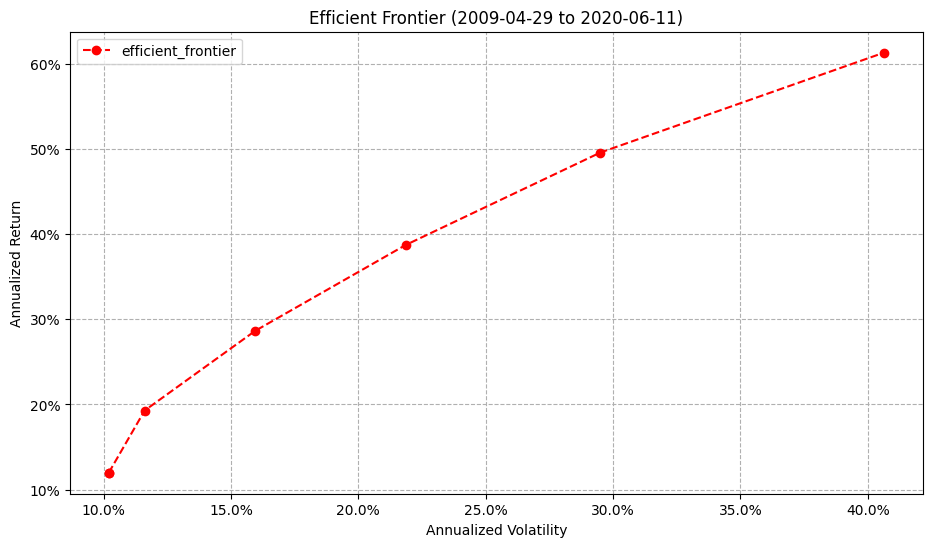

In [103]:
# Plotting efficient frontier
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='efficient_frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier ('+str(start_date)+' to '+str(end_date)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# Evaluating all ML Models Trading Performance

In [ ]:
for model in os.listdir('cache/ml_models/'):
    ml_model = load_pkl_file(f'cache/ml_models/{model}')
    backtester = Backtest(ml_model, rtn_df, OH_X_train, y_train, OH_X_valid, X_valid)
    backtester.display_results()